In [1]:
import numpy as np
import pandas as pd
import functions, importlib
from scipy.stats import pearsonr
import datetime as dt
from numpy import mean
import matplotlib.pyplot as plt
n = 100  # every 100th line = 1% of the lines
df = pd.read_csv("data/steam_reviews.csv", header=0, skiprows=lambda i: i % n != 0)
pd.set_option('display.max_columns', 23)
df.info()
print('Reading finished!')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217473 entries, 0 to 217472
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      217473 non-null  int64  
 1   app_id                          217473 non-null  int64  
 2   app_name                        217473 non-null  object 
 3   review_id                       217473 non-null  int64  
 4   language                        217473 non-null  object 
 5   review                          217120 non-null  object 
 6   timestamp_created               217473 non-null  int64  
 7   timestamp_updated               217473 non-null  int64  
 8   recommended                     217473 non-null  bool   
 9   votes_helpful                   217473 non-null  int64  
 10  votes_funny                     217473 non-null  int64  
 11  weighted_vote_score             217473 non-null  float64
 12  comment_count   

# RQ1: Exploratory Data Analysis (EDA)
We are giver a dataset of reviews of the online gaming platform Steam. Each review is described through a series of attributes.\
The following is a brief summary of the charachteritics of the dataset.

The most relevant features of the dataset are the following: 

In [3]:
functions.summary(df)

Total elemnts in data set: 5,001,879
Number of reviews: 217,473
Number of attributes for each review: 23


,Description
Attibutes of the review,
author.steamid,Author identification number
app_name,Game name
timestamp_created,Date of review
language,Language of the review
review,The review itself
weighted_vote_score,Score of the review
author.playtime_forever,Author total playtime


Number of distinct games: 315
Number of distinct languages: 28
Reviews range from 2010-11-19 to 2021-01-23


# RQ2: Simple insights into the reviews

- Plot the number of reviews for each application in descending order

[]

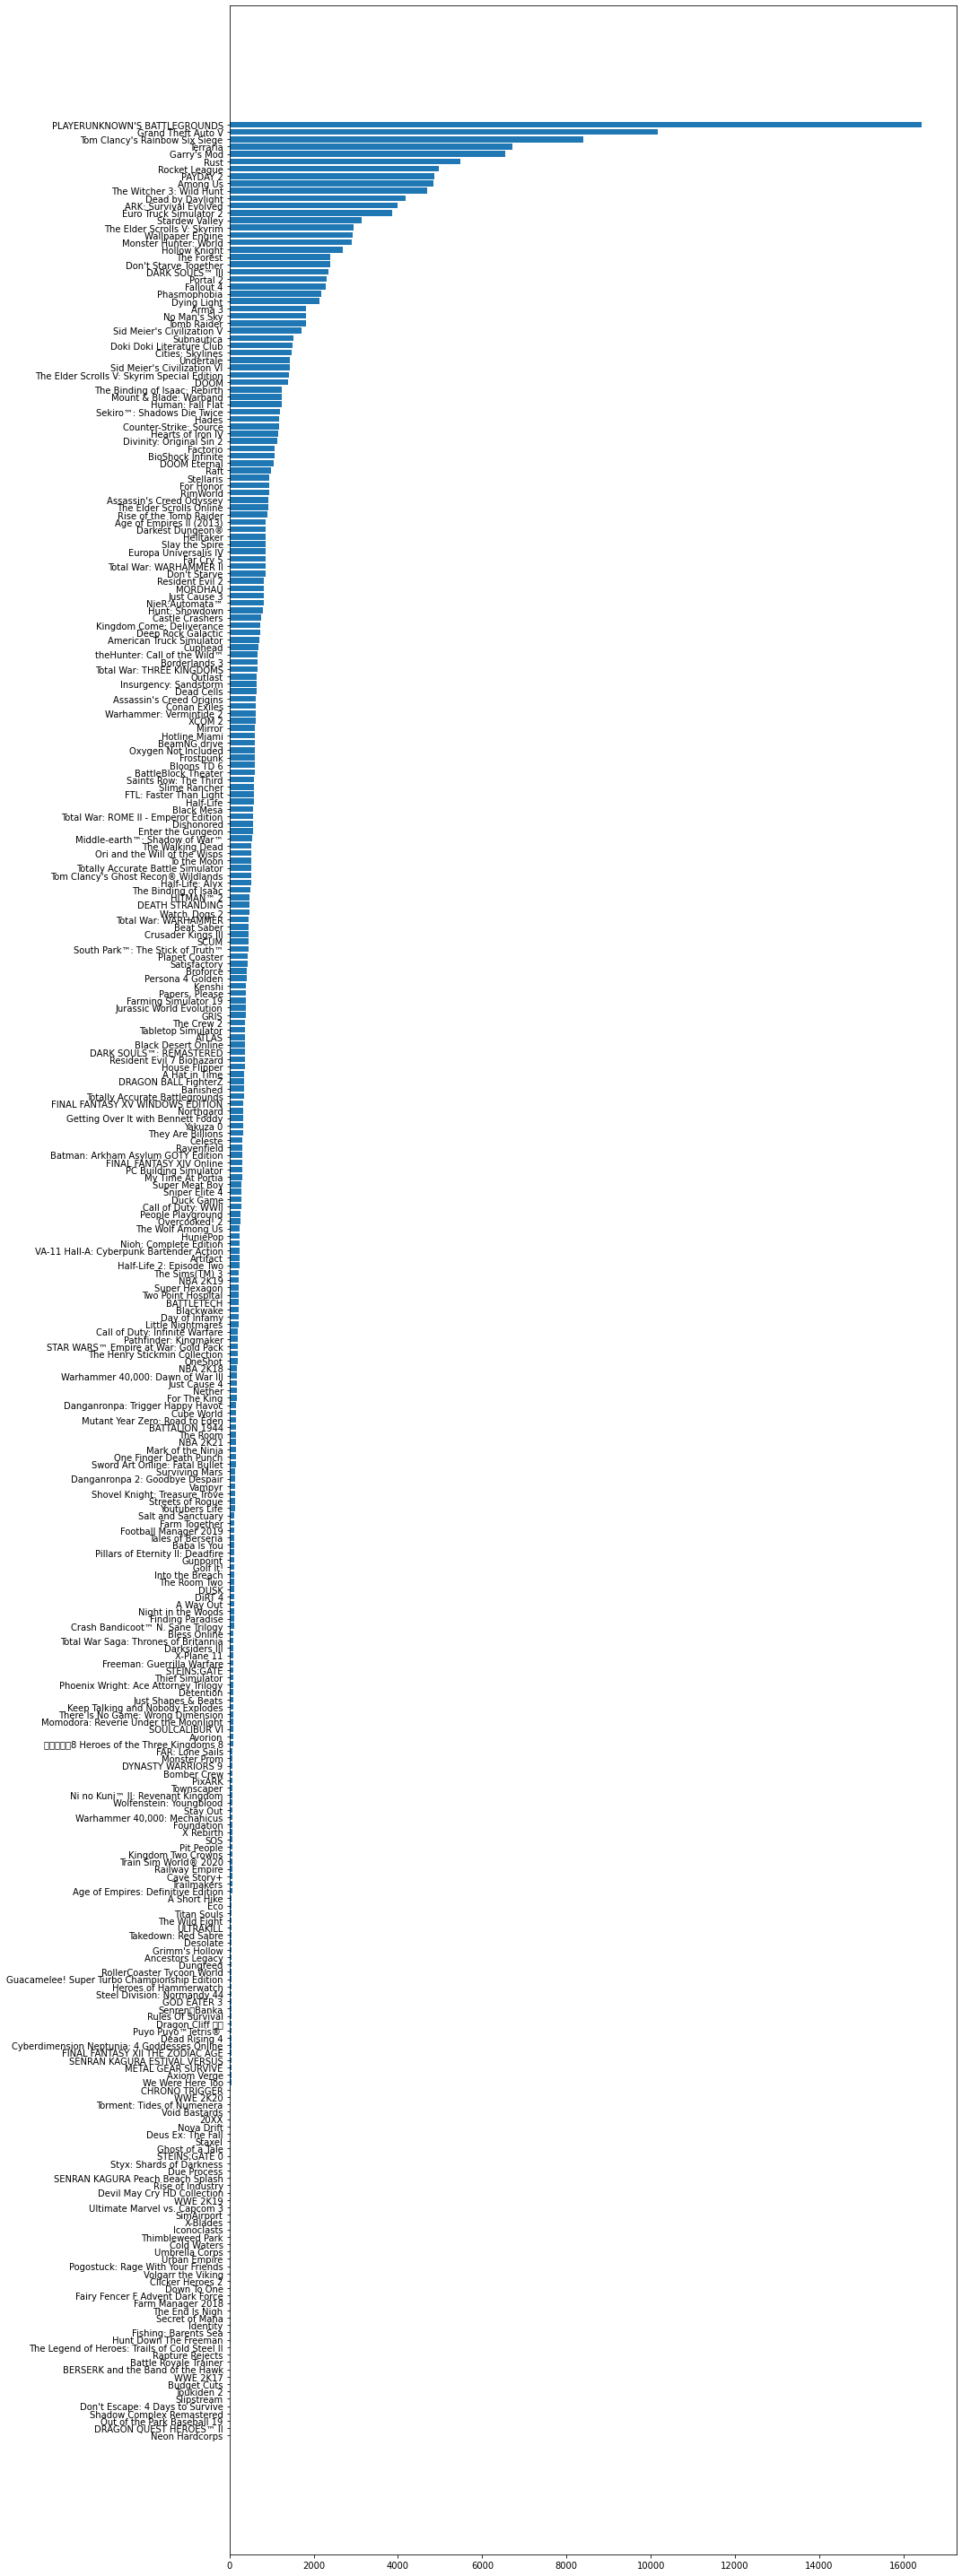

In [34]:
num_of_reviews = df.groupby('app_name')['review'].count().sort_values().to_frame()
fig, ax = plt.subplots(figsize=(15,40))
bar = ax.barh(num_of_reviews.index, num_of_reviews['review'])
plt.tight_layout()
plt.plot()

- What applications have the best Weighted Vote Score?

In [40]:
best_weighted_score = df.groupby('app_name')['weighted_vote_score'].mean().sort_values(ascending=False).to_frame().head(3)
#renaming
best_weighted_score.index.name='Game name'
best_weighted_score.rename(columns={"weighted_vote_score": "Weighted Vote Score"})

,Weighted Vote Score
Game name,
Hunt Down The Freeman,0.533353
BERSERK and the Band of the Hawk,0.479178
Identity,0.463916


- Which applications have the most recommendations?

In [49]:
most_recommendations = df.groupby('app_name')['recommended'].apply(lambda x: (x==True).sum()).sort_values(ascending=False).to_frame().head(3)
#renaming
most_recommendations.index.name='Game name'
most_recommendations.rename(columns={"recommended": "Recommended votes"})

,Recommended votes
Game name,
PLAYERUNKNOWN'S BATTLEGROUNDS,8934
Grand Theft Auto V,8335
Tom Clancy's Rainbow Six Siege,7422


- And the least recommendations?

In [102]:
least_recommendations = df.groupby('app_name')['recommended'].apply(lambda x: (x==False).sum()).sort_values(ascending=False).to_frame().head(3)
#renaming
least_recommendations.index.name='Game name'
least_recommendations.rename(columns={"recommended": "Not recommended votes"})

,Not recommended votes
Game name,
PLAYERUNKNOWN'S BATTLEGROUNDS,7508
Grand Theft Auto V,1856
Tom Clancy's Rainbow Six Siege,997


- How many of these applications were purchased, and how many were given for free?

In [168]:
# the aggregate function
agg_f = {'steam_purchase': lambda x: (x == True).sum(), 'received_for_free': lambda x: (x == True).sum()}

purchesed_or_free = df[['app_name', 'steam_purchase', 'received_for_free']].groupby('app_name').aggregate(agg_f)

#renaming
purchesed_or_free = purchesed_or_free.rename(columns={"steam_purchase": "Purchased", 'received_for_free': 'Recieved for free'})
purchesed_or_free.loc[least_recommendations.index]

,Purchased,Recieved for free
Game name,,
PLAYERUNKNOWN'S BATTLEGROUNDS,13718,593
Grand Theft Auto V,9009,377
Tom Clancy's Rainbow Six Siege,7047,370


# RQ4: Extract some information from languages

- What are the top 3 languages used to review applications?

In [4]:
top3 = list(df['language'].value_counts()[:3].index)

print("The top 3 languages are:")
for language in top3:
    print(language)

The top 3 languages are:
english
schinese
russian


- Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

In [4]:
def lan_filter(df, lans):
    return df[df['language'].apply(lambda x: (x in lans))]

- Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

In [16]:
top3_df = lan_filter(df, top3)
votes = top3_df[top3_df['votes_funny'].apply(lambda x: x >= 1)]
perc_funny = str(round((votes.shape[0] / top3_df.shape[0] ) * 100, 2)) + '%'
print(f"The percentage of funny reviews associated with the top 3 languages is {perc_funny}")

The percentage of funny reviews associated with the top 3 languages is 12.35%


- Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [225]:
votes_helpful = top3_df[top3_df['votes_helpful'] >= 1]
perc_helpful = str(round((votes_helpful.shape[0] / top3_df.shape[0] ) * 100, 2)) + '%'
print(f"The percentage of helpful reviews associated with the top 3 languages is {perc_helpful}")

The percentage of helpful reviews associated with the top 3 languages is 29.17%


# RQ5: How often authors make reviews.

- Plot the top 10 most popular reviewers and the number of reviews.

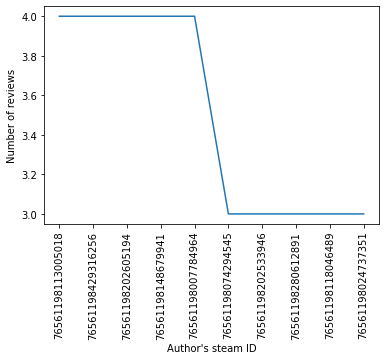

In [32]:
plt.xticks(rotation=90)
plt.xlabel("Author's steam ID")
plt.ylabel("Number of reviews")
top10reviewers = df['author.steamid'].value_counts()[:10]
x = top10reviewers.index.map(lambda x: str(x))
y = top10reviewers.values
plt.plot(x, y)

- What applications did the most popular author review?

In [9]:
top1_author = top10reviewers.index[0]
top1_author_df = df[df['author.steamid'] == top1_author]
top1_author_games = list(top1_author_df['app_name'].unique())
print("The most popular author reviewd:")
for game in top1_author_games:
    print(game)

The most popular author reviewd:
Rust
Rocket League
PLAYERUNKNOWN'S BATTLEGROUNDS
SCUM


- How many applications did he purchase, and how many did he get as free? Provide the number (count) and the percentage.

In [12]:
p = top1_author_df[top1_author_df['steam_purchase'] == True].shape[0]
f = top1_author_df[top1_author_df['received_for_free'] == True].shape[0]

perc_p = str(round((p / top1_author_df.shape[0] ) * 100, 2)) + '%'
perc_f = str(round((f / top1_author_df.shape[0] ) * 100, 2)) + '%'

print(f"The most popular author purchased {perc_p} of it's games, and got for free {perc_f} of it's games.")

The most popular author purchased 50.0% of it's games, and got for free 25.0% of it's games.


- How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?

In [30]:
purchased_reviewed_positively  = len(top1_author_df[(top1_author_df['steam_purchase'] == True) & (top1_author_df['recommended'] == True)])
purchased_reviewed_negatively = len(top1_author_df[(top1_author_df['steam_purchase'] == True) & (top1_author_df['recommended'] == False)])
free_reviewed_positively = len(top1_author_df[(top1_author_df['received_for_free'] == True) & (top1_author_df['recommended'] == True)])
free_reviewed_negatively = len(top1_author_df[(top1_author_df['received_for_free'] == True) & (top1_author_df['recommended'] == False)])

print(f"The most popular author:\n- reviewed positively {purchased_reviewed_positively} of the games he purchased,\n- reviewed negatively {purchased_reviewed_negatively} of the games he purchased,\n- reviewed positively {free_reviewed_positively} of the games he got for free and \n- reviewed negatively {free_reviewed_negatively} of the games he got for free.")

The most popular author:
- reviewed positively 1 of the games he purchased,
- reviewed negatively 1 of the games he purchased,
- reviewed positively 1 of the games he got for free and 
- reviewed negatively 0 of the games he got for free.


# RQ7: Computing probabilities

- What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?

In [33]:
# data frame of reviews with score equal or bigger than 0.5
df_good_score = df[df['weighted_vote_score'] >= .5]

# n of reviews of the df
n_good_score = df_good_score.shape[0]

#total n of reviews
total =  df.shape[0]
print(f'The probability that a review has a Weighted Vote Score equal \
to or bigger than 0.5 is {n_good_score / total:.2%}')

The probability that a review has a Weighted Vote Score equal to or bigger than 0.5 is 21.96%


- What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?

In [41]:
df_good_score_and_funny = df_good_score[df_good_score['votes_funny'] != 0]
n_good_score_and_funny =  df_good_score_and_funny.shape[0]

print(f'The probability that a review has at least one vote as funny given that \n\
the Weighted Vote Score is bigger than 0.5 is {n_good_score_and_funny / n_good_score:.2%}')

The probability that a review has at least one vote as funny given that 
the Weighted Vote Score is bigger than 0.5 is 24.72%


- Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?

Two events $A$ and $B$ are independant if $P(A|B) = P(A)$.\
For events $A = \textrm{"review has at least one vote as funny"}$ and $B = \textrm{"Weighted Vote Score is bigger than 0.5"}$ indepandancy could be verified calculating $P(A)$.

In [39]:
df_funny = df[df['votes_funny'] != 0]
n_funny = df_funny.shape[0]
print(f'The probability that a review has at least one vote as funny is {n_funny / total:.2%}')

The probability that a review has at least one vote as funny is 12.04%


And so in conclusione the two events are not idependant.

# RQ 8

- Is there a significant difference in the Weighted Vote Score of reviews made in Chinese vs the ones made in Russian? Use an appropriate statistical test or technique and support your choice.

From a graphical analysis it is evident the two distributions are correlated, the values follow the same pattern distribution with the exception of the amount of zero score reviews, this is reflected in the mean of the weighted vote score that is for: 
- russian reviews:  0.21
- chinese reviews:  0.15
This is consequence of the larger weight of the chinese zero score reviews.


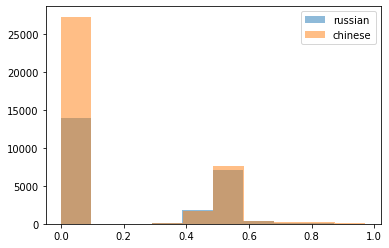

In [13]:
df_ru = lan_filter(df, ['russian'])
df_ch = lan_filter(df, ['schinese'])

ru_vals = df_ru['weighted_vote_score'].values
ch_vals = df_ch['weighted_vote_score'].values

# plt.hist([ru_vals, ch_vals], bins=7, edgecolor='black')
plt.hist(ru_vals, bins=10, label='russian', alpha=0.5)
plt.hist(ch_vals, bins=10, label='chinese', alpha=0.5)
plt.legend(loc='upper right')

print(f'From a graphical analysis it is evident the two distributions are correlated, \
the values follow the same pattern distribution with the exception of the amount of zero score reviews, \
this is reflected in the mean of the weighted vote score that is for: \n\
- russian reviews: {mean(ru_vals): .2f}\n\
- chinese reviews: {mean(ch_vals): .2f}\n\
This is consequence of the larger weight of the chinese zero score reviews.')

- Can you find any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score? Use an appropriate statistical test or technique and support your choice.

The distribution of the reviews is expressed as the sum of two distributions with:
1) reviews with score equal to 0
2) reviews with score different than 0

Some remarks:
- Reviews are considered updated after one day from the moment of creation in order to exclude trivial editings as typos.
- The time interval between review creation and last update is expressed in years because this resolution is the closest to the mean of the time interval

Pearson correlations coefficient is:  -0.03896013380775387
This coefficient is really close to 0, which means there is no evident correlation between the two variables using this specific correlation test


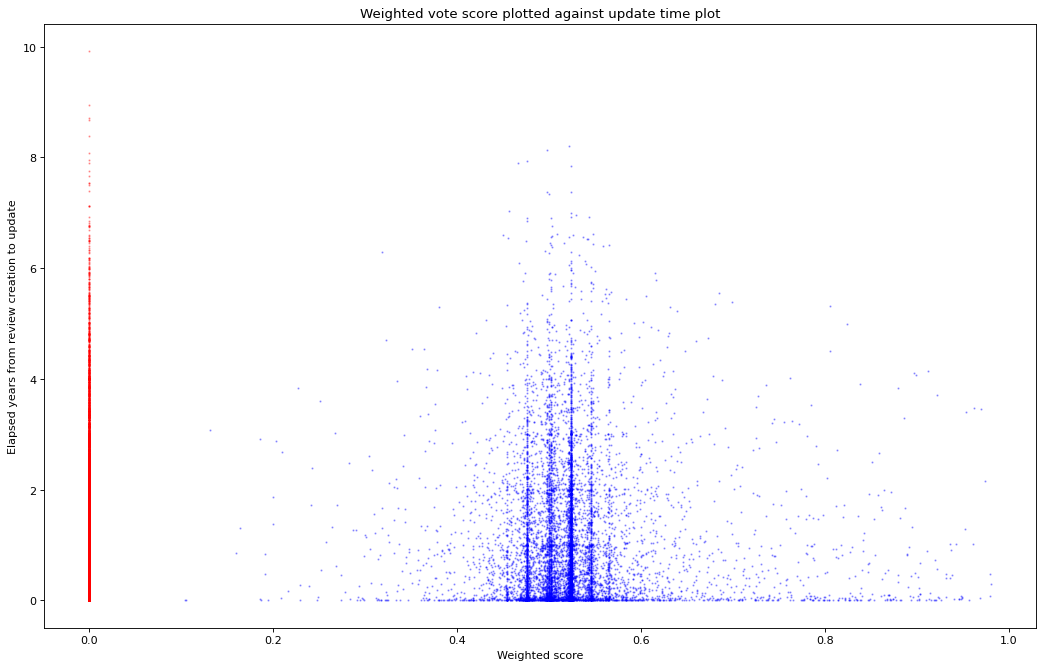

In [23]:
# defining constants
one_day = 86400 # number of seconds in a day
one_year = 31556926 # number of seconds in a year

# the two distinct dataframes
valid_updates = df[(df['timestamp_updated'] - df['timestamp_created'] > one_day)]

valid_updates_non_zero_score = valid_updates[valid_updates['weighted_vote_score'] != 0]
valid_updates_zero_score = valid_updates[valid_updates['weighted_vote_score'] == 0]

# the values of the score
non_zero_score = valid_updates_non_zero_score['weighted_vote_score'].values
zero_score = valid_updates_zero_score['weighted_vote_score'].values

# the values of the time interval between review creation and last update
delta_t_update_non_zero_score = (valid_updates_non_zero_score['timestamp_updated'] - \
                  valid_updates_non_zero_score['timestamp_created']).apply(lambda x: x/one_year).values
delta_t_update_zero_score = (valid_updates_zero_score['timestamp_updated'] - \
                  valid_updates_zero_score['timestamp_created']).apply(lambda x: x/one_year).values

# Pearson correlation test
corr, _ = pearsonr(non_zero_score, delta_t_update_non_zero_score)
print('Pearson correlations coefficient is: ', corr)
print('This coefficient is really close to 0, \
which means there is no evident correlation between the two variables using this specific correlation test')

# plot
fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
ax.scatter(non_zero_score, delta_t_update_non_zero_score, s=1, c='blue', alpha=0.3)
ax.scatter(zero_score, delta_t_update_zero_score, s=1, c='red', alpha=0.3)
ax.set_xlabel('Weighted score')
ax.set_ylabel('Elapsed years from review creation to update')
plt.title("Weighted vote score plotted against update time plot")
plt.show()

In [128]:
# computing how many unaptated reviews have score zero 
no_updates = df[(df['timestamp_updated'] - df['timestamp_created'] < one_day)]
no_updates_score = no_updates['weighted_vote_score'].values
zero_score_no_updates = len(no_updates_score) - np.count_nonzero(no_updates_score)

print(f'It is computed that {len(non_zero_score) / valid_updates.shape[0]:.2%} of the updated reviews \
have score zero while {zero_score_no_updates/len(no_updates_score):.2%} of the unaptadeted reviews have score zero. So it is deduced that there \
is correletion between non zero score reviews and updating a review.')

It is computed that 48.36% of the updated reviews have score zero while 69.43% of the unaptadeted reviews have score zero. So it is deduced that there is correletion between non zero score reviews and updating a review.


- Is there any change in the relationship of the variables mentioned in the previous literal if you include whether an application is recommended or not in the review? Use an appropriate statistical test or technique and support your choice.

Pearsons correlation coefficient of weighted vote score and the update time for recommended apps:  -0.0005270549564296383
Pearsons correlation coefficient of weighted vote score and the update time for non-recommended apps"  -0.030419713698188813
Both coefficient are close to 0, which, in the case of Pearsons correlation, means that the variables are almost not correlated. Other statistical correlation tests could be used.
The Pearsons coefficient is lower: -0.030419713698188813 ,if we consider the case of non-recommended apps. So it drops in that case. Nevertheless, in all cases, it is too close to zero to consider any relationship
The scatter plots visualize one variable plot against the other one. There is not an apparent relationship


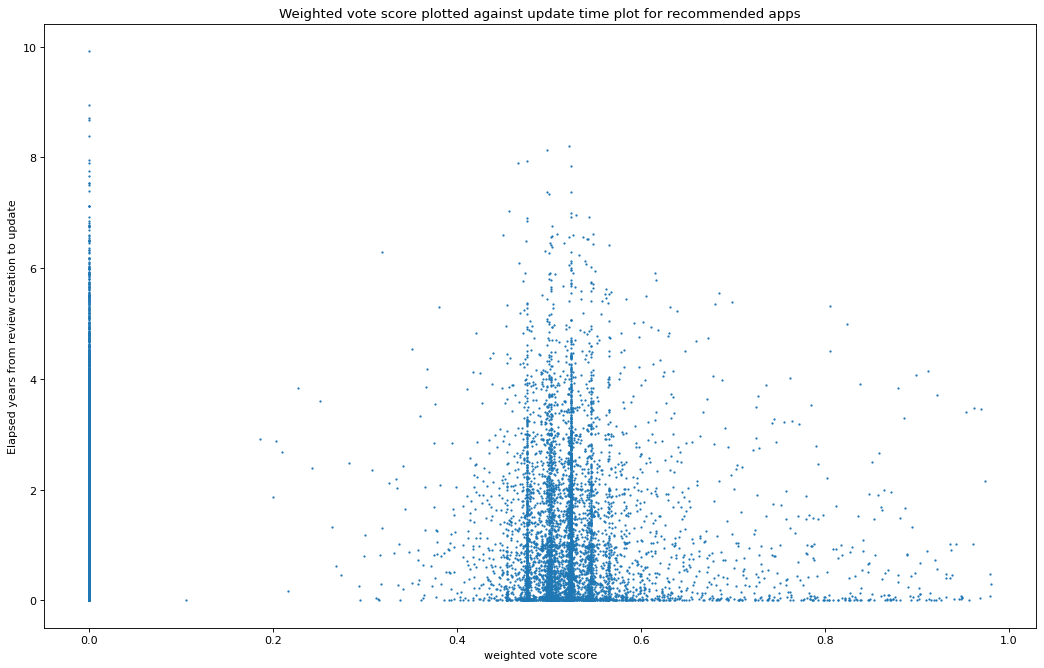

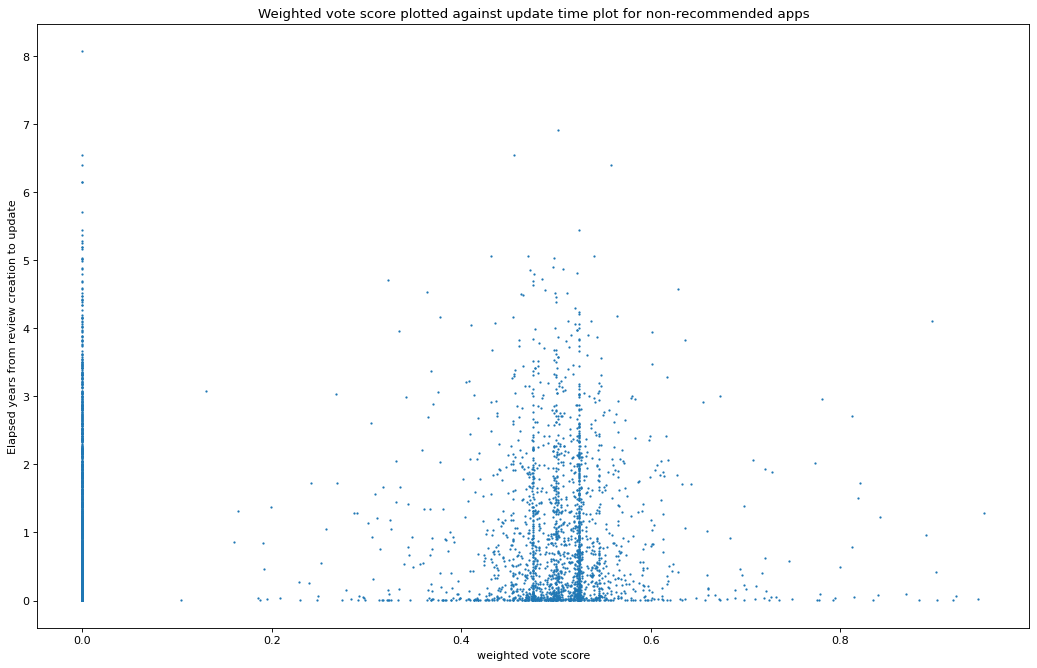

In [22]:
updates_p = valid_updates[valid_updates['recommended'] == True]
updates_n = valid_updates[valid_updates['recommended'] == False]

x1 = (updates_p['timestamp_updated'] - updates_p['timestamp_created']).apply(lambda x: x/one_year).values
x2 = (updates_n['timestamp_updated'] - updates_n['timestamp_created']).apply(lambda x: x/one_year).values

y1 = updates_p['weighted_vote_score'].values
y2 = updates_n['weighted_vote_score'].values

corr1, _ = pearsonr(x1, y1) # The pearson's correlation coefficient of the recommended apps
corr2, _ = pearsonr(x2, y2) # The pearson's correlation coefficient of non-recommended apps

print('Pearsons correlation coefficient of weighted vote score and the update time for recommended apps: ', corr1)
print('Pearsons correlation coefficient of weighted vote score and the update time for non-recommended apps" ', corr2)

print('Both coefficient are close to 0, which, in the case of Pearsons correlation, \
means that the variables are almost not correlated. Other statistical correlation tests could be used.')
print('The Pearsons coefficient is lower:', str(corr2), ',if we consider the case of \
non-recommended apps. So it drops in that case. Nevertheless, in all cases, it is too close to zero to consider any relationship')

# fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.figure(figsize=(16, 10), dpi=80)
plt.scatter(y1, x1, s=1)

plt.title("Weighted vote score plotted against update time plot for recommended apps")
plt.xlabel("weighted vote score")
plt.ylabel('Elapsed years from review creation to update')

plt.figure(figsize=(16, 10), dpi=80)
plt.scatter(y2, x2, s=1)
plt.title("Weighted vote score plotted against update time plot for non-recommended apps")
plt.xlabel("weighted vote score")
plt.ylabel('Elapsed years from review creation to update')

print('The scatter plots visualize one variable plot against the other one. There is not an apparent relationship')

In [53]:
# What are histograms, bar plots, scatterplots and pie charts used for?

# Histograms, bar plots and scatter plots are various visualization
# method that we can find in data science. They are used to graphically
# plot data so it can be eventually easier understood.

# Histogram - it is a way to visualize data in the following way: we have 
# a number of bins n,, which means that we are going to have n rectangles
# one next to each other , evenly spread in the x axis (with equal width). 
# Each histogram's (h_i) height is going to be the number of samples that 
# have value that is in the range [h_i[0], h_i[1]], where h_i[0] and h_i[1]
# are the starting and the ending point of histogram h_i in the x axis. 
# Histograms are used to plot the distribution of the data.

# Bar plot is somewhat similar to histogram in terms of how it looks, but
# it is not the same. It compares two variables by showing, for example, 
# categories and number of samples in a specific category. Unlike
# histograms, the number of bins is fixed (depending on the categories),
# we could change the positions of the categories on the x axis, and it
# won't make difference (unlike in histogram).

# Pie chart is a often used visualization mean in data science. It is used
# to present the proportion of data classes in a circle. The whole circle
# represents the "universe", that is, all possible classes.

# Box plots are also a visualization method, they show the minimum, 
# the maximum values in groups of a sample of data, as well as the 
# median and first and third quartiles. The first quartile is the 
# number that is between the minimum and the median of the data set. 
# The third quartile is the middle number between the median and the 
# maximum value in the group. Box plots also show the outliers of the data.



# TQ1

1. What does the algorithm compute?

Assigning a value to every element of $A$, the algorithm computes the $k$th element, in order of value, of $A$. The algorithm achieves this result without sorting the elements of $A$ itself.\
For example if the elements of $A$ are integers the output will be $k$th biggest integer:

then $alg(A, k) = 6$

2. What is asymptotically (i.e., we are asking for big-O complexity) the running time of the algorithm in the worst case, as a function of n?

The first operation consists of $n-1$ comparisons of the element $s$ with all the other $n-1$ elements.\
In the worst case scenaio the input set decreases by only one element at every iteration and so the second time we have $n-2$ comparisions, then $n-3$ and so on. The total number of operations is then:\
$(n-1) + (n-2) +\ ...\ + 1 < n^2$\
and so:\
$alg(A, k) = O(n^2)$

3. What is asymptotically the running time of the algorithm in the best case?

In the best case scenario $r=k$ on the first iteration and so the algorithm computes only the first $n-1$ comparisons.\
$alg(A, k) = O(n)$

# TQ2

- How much running time does it take to execute splitSwap(a, 0, n)? (We want a Big O analysis.)

Without loss of generality, assume len(a) = n, so that the function actually considers the whole array (l and n are the the bounds of what will be considered, but for l != n an array will be considered, so we don't lose generality with this assumption).

NOTE
----
For the rest of this exercise (TQ2), I will consider log(x) to be the the logarithm of x, base 2.

Statement:

T(n) is O(n*logn)



Proof: (using Master theorem)

It can be seen that T(n) = T(n/2) + T(n/2) + n/2
(because, the function is recursively called on the first half of the input data, then on the second half of the input data, then an operation is executed which loops over half of the elements of the input size (in the loop there are only a fixed number of operations independent of n)). 

T(n) = 2*T(n/2) + n/2

Using the Master Theorem (https://www.jntua.ac.in/gate-online-classes/registration/downloads/material/a15928166316.pdf, https://en.wikipedia.org/wiki/Master_theorem_(analysis_of_algorithms), https://www.google.com/search?channel=fs&client=ubuntu&q=master+theorem+cases)

-------------------------------------------
T(n) is trivially monotonically increasing, 

T(n) = a * T(n/b) + f(n) (where f(n) is O(n^d)). In our case , a =2, b=2 and f(n) = O(n^1) => d = 1, because n/2 is O(n^1)

T(1) = c (a constant number of operations in the base case, in our case - c=1 for the return statement)

Thus this function satisfies Master theorem conditions and we can directly apply it: 

since a = 2 and b^d = 2 ^ 1 = 2 => a = b => T(n) is θ((n^d) * log(n)) (by Master theorem). Since d=1, T(n) is θ(n * log(n)) . 

Since T(n) is θ(n * log(n)), it also follows that T(n) is O(n * log(n))

-------------------------------------------



<!-- Unfold: 

T(n) = 2*((2*T(n/4) + n/4) + n/2 = 4*T(n/4) + n

Unfold

T(n) = 4*(2*T(n/8) + n/8) + n = 8*T(n/8) + (3n)/2

Keep unfolding to get 

T(n) = (2^k) * T(n/(2^k)) + (k*n)/2

By following this logic, k is obviously a natural number.

Try to reach the base case by setting n/(2^k) = 1 

<=>

2^k = n 

<=>

k = logn 

Here we assume that n is power of 2 so k is indeed an integer.

Now substitute to get:

T(n) = 
(2 ^ (logn)) * T(1) + (n * logn)/2 
= n*T(1) + (n*logn)/2
= n + (n*logn)/2

=> T(n) is n*logn
 -->



- What does this algorithm do? Is it optimal? Describe the mechanism of the algorithm in details, we do not want to know only its final result.


The algorithm reverses the numbers in the list in the range [l, n]
This can be verified by inspecting the algorithm and also transforming it to code and running it. 
The respective code is: 


In [68]:
import math
def splitSwap(a, l, n):
    if n <= 1:
        return a
    k = math.ceil(n / 2)
    splitSwap(a, l, k)
    splitSwap(a, l + k, k)
    swapList(a, l, n)
    return a


def swapList(a, l, n):
    k = math.ceil(n / 2)
    for i in range(0, k):
        tmp = a[l + i]
        a[l + i] = a[l + k + i]
        a[l + k + i] = tmp
    print('A is: ', a)

print(splitSwap([1, 2, 3, 4, 5, 6, 7, 8], 0, 2))
print(splitSwap([1, 2, 3, 4, 5, 6, 7, 8], 0, 4))
print(splitSwap([1, 2, 3, 4, 5, 6, 7, 8], 0, 5))
print(splitSwap([1, 2, 3, 4, 5, 6, 7, 8], 0, 7))

A is:  [2, 1, 3, 4, 5, 6, 7, 8]
[2, 1, 3, 4, 5, 6, 7, 8]
A is:  [2, 1, 3, 4, 5, 6, 7, 8]
A is:  [2, 1, 4, 3, 5, 6, 7, 8]
A is:  [4, 3, 2, 1, 5, 6, 7, 8]
[4, 3, 2, 1, 5, 6, 7, 8]
A is:  [2, 1, 3, 4, 5, 6, 7, 8]
A is:  [2, 1, 4, 3, 5, 6, 7, 8]
A is:  [4, 3, 2, 1, 5, 6, 7, 8]
A is:  [4, 3, 2, 5, 1, 6, 7, 8]
A is:  [4, 3, 2, 5, 1, 7, 6, 8]
A is:  [4, 3, 2, 7, 6, 5, 1, 8]
A is:  [7, 6, 5, 4, 3, 2, 1, 8]
[7, 6, 5, 4, 3, 2, 1, 8]
A is:  [2, 1, 3, 4, 5, 6, 7, 8]
A is:  [2, 1, 4, 3, 5, 6, 7, 8]
A is:  [4, 3, 2, 1, 5, 6, 7, 8]
A is:  [4, 3, 2, 1, 6, 5, 7, 8]
A is:  [4, 3, 2, 1, 6, 5, 8, 7]
A is:  [4, 3, 2, 1, 8, 7, 6, 5]
A is:  [8, 7, 6, 5, 4, 3, 2, 1]
[8, 7, 6, 5, 4, 3, 2, 1]


The algorithm is not optimal, because, for example, to reverse an array, it takes n*logn time. An array A can also be reversed in O(n) time with the operation: A[::-1] , which iterates the whole array with step size -1 (starting from the end). 

The same applies if only a sub-array of the original array is chosen, since it will recursively be called and the complexity would be O(len(subarray) * log(len(subarray))) , while it can be reversed in O(len(subarray)) time.

Description of the algorithm:

Let's consider the case when l=0 and n=len(a). Otherwise, the array will just be sampled (with the two recursive calls that take first and second halfs of the original array, respectively, and the last line which also considers the sample, (the sample starts at l and ends at n)). In the picture there is detailed description of what the algorithm does
at each step and finally, it shows the result. This generalizes to array of any size (of course, we are bounded by some computational power limit).
 
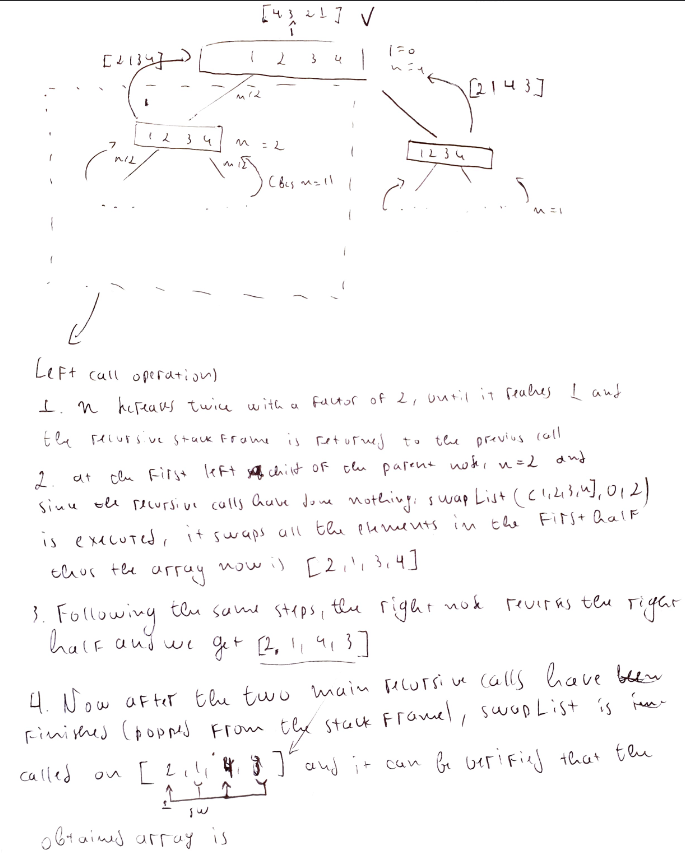


# TQ3